In [44]:
import pandas as pd
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
# set sns style to sci
sns.set_style("whitegrid")

sys.path.append("../")
from UpStraight_Data import preprocess

In [20]:
# for each file in the data folder, read the csv, and add a column with the suffix of the file name
# this will be used to identify the source of the data

df = pd.concat([pd.read_csv(f"../data/{f}").assign(source = f.split(".")[0].split("_")[1]) for f in os.listdir("../data") if f.startswith("export_")])
df.shape

(386, 4)

In [21]:
data = preprocess(df)
data.dtypes

date              datetime64[ns, UTC]
state                           int64
posture                         int64
source                         object
day                             int64
time                           object
state_string                   object
posture_string                 object
dtype: object

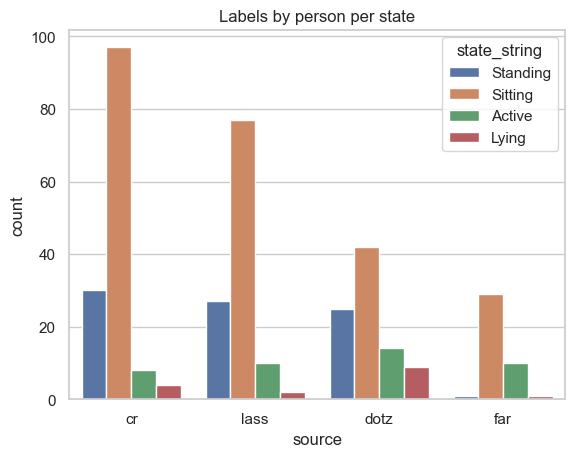

In [48]:
# plotting relative proportions of each state
sns.countplot(data,x="source",hue="state_string")
plt.title("Labels by person per state")
plt.show()

In [76]:
# summary table of counts by source and state
data.groupby(["source","state_string"]).size().unstack().fillna(0).astype(int)


state_string,Active,Lying,Sitting,Standing
source,,,,
cr,8,4,97,30
dotz,14,9,42,25
far,10,1,29,1
lass,10,2,77,27
